In [1]:
from __future__ import division
import numpy as np
from acoustics.signal import EqualBand, OctaveBand, Signal, Spectrum
from acoustics.generator import Generator
from acoustics.building_acoustics_measurement import BuildingAcousticsMeasurement
import math
import matplotlib.pyplot as plt

DEBUG = True

In [2]:
class Test(object):
    def __init__(self, fs=44100, duration=10.0, n_channels=1, f_start=100., f_stop=5000., fraction=3, signal=None, response=None, noise_type='pink', state=None):
        if signal is not None:
            # ToDo: Case where a signal is given
            pass
        if response is not None:
            # Case where the measured response is given
            pass
        self._fs = fs
        self._f_start = f_start
        self._f_stop = f_stop
        self._fraction = fraction
        
        self.gen = Generator(fs, duration, state) #generate n_channels dimension signal
        if noise_type == 'sine_sweep':
            self.signal, self.reverse_signal = self.gen.noise(noise_type, [f_start, f_stop])
        else:
            self.signal = self.gen.noise(noise_type)
        self.signal = self.signal[None, ...]
        self.building_acoustics = BuildingAcousticsMeasurement(f_start=100., f_stop=3150., fraction=fraction)
        
        
        if DEBUG:
            print("Sample length : {0}").format(self.signal.shape[-1])
            
    
    def simulate_measured_signal(self):
        pass
    
    def filter_octaves(self):
        """
        Bandpass filter the test signal for each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands
        and filtered signals for each octave band, and for each input channel.
        """
        signal_processor = Signal()
        frequencies = OctaveBand(fstart=self._f_start, fstop=self._f_stop, fraction=self._fraction)
        _, filtered_signal = signal_processor.bandpass_fractional_octaves(self.signal, self._fs, frequencies)
        
        return frequencies.center, filtered_signal
    
    
    def octave_spectrum(self):
        """
        Compute the power level of each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands and their respective power level
        """
        spectrum = Spectrum()
        frequencies = OctaveBand(fstart=self._f_start, fstop=self._f_stop, fraction=self._fraction)
        _, ocataves_power, ocataves_power_levels = spectrum.third_octaves(self.signal, self._fs, frequencies=frequencies.center)
        
        return frequencies.center, ocataves_power_levels
    
    
    def spl_computation(self):
        """
        Simulate measured sound int the transmitting and receiving room, and compute their respective SPL
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        Return the calculated SPL in the transmitting and the receiving room.
        """   
        # Simulate measured signal
        tx_room_attenuation = 0.9
        tx_room_noise_rms = 0.01
        tx_room_response_signal = self.gen.simulate_measured_signal(self.signal,  attenuation=tx_room_attenuation, noise_rms=tx_room_noise_rms)

        rx_room_attenuation = 0.01
        rx_room_noise_rms = 0.03
        rx_room_response_signal = self.gen.simulate_measured_signal(self.signal,  attenuation=rx_room_attenuation, noise_rms=rx_room_noise_rms)
        
        # Compute rooms' SPL
        self.building_acoustics.compute_spl('tx', tx_room_response_signal)
        self.building_acoustics.compute_spl('rx', rx_room_response_signal)
        tx_room_spl = self.building_acoustics.tx_room_spl
        rx_room_spl = self.building_acoustics.rx_room_spl
        
        return tx_room_spl, rx_room_spl
        
    def R(self):
        # Measure SPL in transmitting and receiving rooms
        tx_room_spl, rx_room_spl = self.spl_computation()
        
        # Compute tranmission loss
        R = self.building_acoustics.R(10, 125)
        
        return R
    
    def DnT(self):
        # Measure SPL in transmitting and receiving rooms
        tx_room_spl, rx_room_spl = self.spl_computation()
        
        # Compute tranmission loss
        DnT = self.building_acoustics.DnT()
        
        return DnT
    
    def rw_curve(self, tl):            
        # Compute tranmission loss
        single_number, ref_curve = self.building_acoustics.compute_single_number(tl)
        
        return single_number, ref_curve
    
    def adpation_term(self, tl, single_number):
        c, c_tr = self.building_acoustics.compute_adaptation_terms(tl, single_number)
        
        print("C = {0}.  C_tr = {1}").format(c, c_tr)
    
    def reverberation_time(self, signal, fs, method, rt):
        self.building_acoustics.compute_reverberation_time('rx', signal, fs, method, rt)
        return self.building_acoustics.reverberation_time

In [7]:
def main():
    fs = 44100
    duration = 10
    f_start=100.
    f_stop=3150.
    fraction = 3 # ToDo: generalize pipeline to fraction = 1
    noise_type='pink'
    
    test = Test(noise_type=noise_type, f_start=f_start, f_stop=f_stop, fraction=fraction)
    
    octave_bands, filtered_signal = test.filter_octaves()
    octave_bands, octaves_power_levels = test.octave_spectrum()
    tx_room_spl, rx_room_spl = test.spl_computation()
    R = test.R()
    R_w, ref_curve = test.rw_curve(R)
    
    DnT = test.DnT()
    DnT_w, ref_curve = test.rw_curve(R)
    test.adpation_term(R, R_w)
    print("Rw = {0}. DnT,w = {1}").format(R_w, DnT_w)
    
    # Test reverberation time calculation
    import wavio
    ir_file = '../../data/ir1_-_iringresso_new.wav'
    ir = wavio.read(ir_file)
    ir_data = ir.data[0:, 0]
    ir_fs = ir.rate
    #print("IR : {0}").format(ir_data.shape)
    reverberation_time = test.reverberation_time(ir_data, ir_fs, 'impulse', 't10')
    
    '''room_response = wavio.read( '../../data/home/record_sweep_3.wav' )
    rr = room_response.data[:,0]
    rr = rr / math.pow(2.0, room_response.sampwidth*8-1)
    ir_data = test.gen.estimate_impulse_response(rr, test.reverse_signal)
    ir_data = ir_data#[:44100*0.6]
    ir_fs = room_response.rate
    print ("SS room response : {0}. IR : {1}. Norm Term : {2}").format(rr.shape, ir_data.shape, pow(2.0, room_response.sampwidth*8-1))
    
    plt.plot(np.arange(ir_data.size)/ir_fs ,ir_data)
    plt.title("Impulse response")
    plt.show()
    reverberation_time = test.reverberation_time(ir_data, ir_fs, 'impulse', 't10')
    plt.plot(octave_bands, reverberation_time)
    plt.title('Reverberation time')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Reverberation Time [sec]')
    plt.grid()
    plt.show()'''
    
    if DEBUG:
        print("Octave bands : {0} . Range {1}Hz to {2}Hz.\
               \nFiltered signal : (octaves,n_channels,sequence_length) : {3}")\
              .format(octave_bands.size, octave_bands[0], octave_bands[-1], filtered_signal.shape)
        
        test_channel = 0
        
        test_band = 0
        test_duration = 2
        T = fs * test_duration
        t = np.arange(T) / fs
        
        plt.title('Test signal. {0} seconds window.'.format(test_duration))
        plt.plot(t, test.signal[test_channel, :T])
        plt.show()
        
        plt.title('1/{0} octave filtered signal, for center freq={1}'\
                  .format(fraction, octave_bands[test_band]))
        plt.plot(t, filtered_signal[test_band, test_channel, :T])
        plt.show()
        
        plt.title('1/{0} octave power spectrum'.format(fraction))
        plt.plot(octave_bands, octaves_power_levels[test_channel])
        plt.xscale('log')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, tx_room_spl[test_channel, ...])
        plt.title('Transmitting room SPL spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.xscale('log')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, rx_room_spl[test_channel, ...])
        plt.title('Receiving room SPL spectrum')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.xscale('log')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, R[test_channel, ...])
        plt.title('R')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.xscale('log')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, ref_curve[test_channel, ...])
        plt.plot(octave_bands, R[test_channel, ...])
        plt.title('Rw curve vs Transmission loss spectrums')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('SPL [dB]')
        plt.xscale('log')
        plt.grid()
        plt.show()
        
        plt.plot(octave_bands, reverberation_time)
        plt.title('Reverberation time')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Reverberation Time [sec]')
        plt.xscale('log')
        plt.grid()
        plt.show()

Sample length : 441000
C = 0.  C_tr = 0
Rw = 31. DnT,w = 31


acoustics\building_acoustics_measurement.py:318: RuntimeWarning: divide by zero encountered in log10
  sch_db = 10.0 * np.log10(sch / np.max(sch))


Octave bands : 16 . Range 100.0Hz to 3162.27766017Hz.               
Filtered signal : (octaves,n_channels,sequence_length) : (16L, 1L, 441000L)


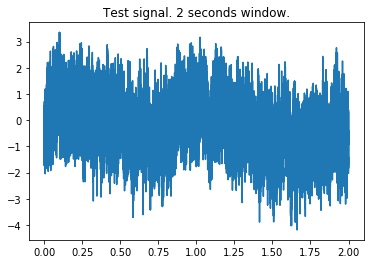

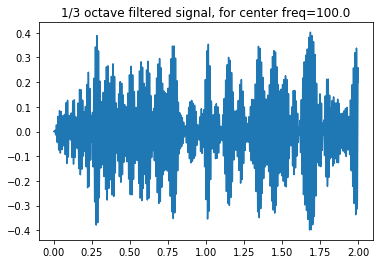

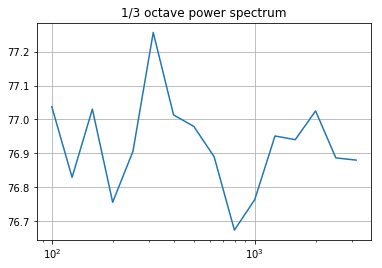

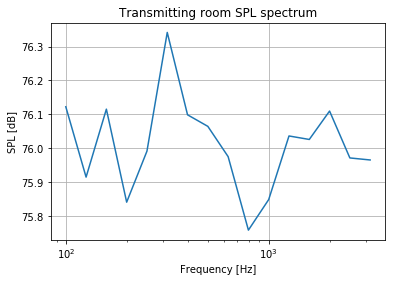

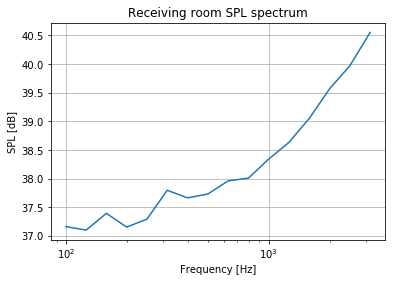

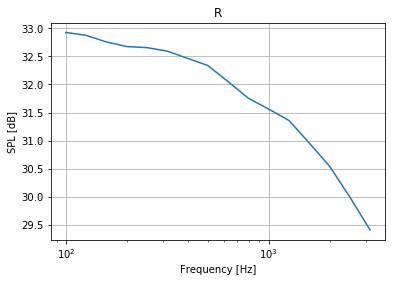

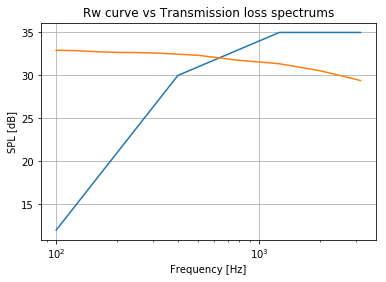

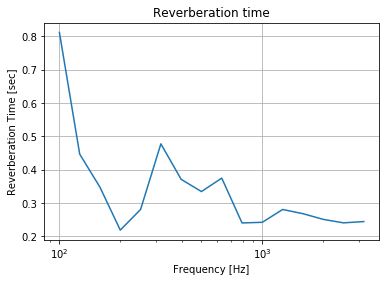

In [8]:
main()

IR : (101559L,)


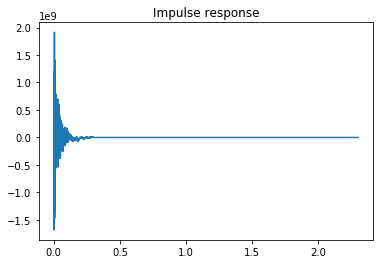

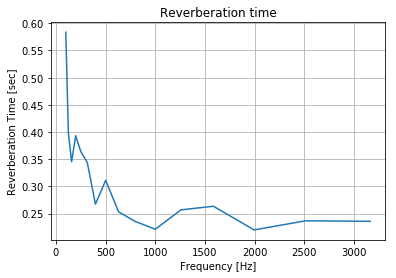

In [22]:
main()

In [2]:
gen = Generator()

In [11]:
signal, response = gen.noise('sine_sweep')
#

In [34]:
math.pow(2, 3)
pow(2, 15)

32768

In [18]:
from scipy.interpolate import UnivariateSpline
old_indices = np.arange(0,a.size)
new_length = 20
new_indices = np.linspace(0,len(a)-1,new_length)
spl = UnivariateSpline(old_indices,a,k=3,s=0)
new_array = spl(new_indices)
np.round(new_array, decimals=2)

array([ 0.  ,  0.47,  0.95,  1.42,  1.89,  2.37,  2.84,  3.32,  3.79,
        4.26,  4.74,  5.21,  5.68,  6.16,  6.63,  7.11,  7.58,  8.05,
        8.53,  9.  ])

In [2]:
gen = Generator()
probe_pulse, reverse_pulse = gen.sine_sweep([100., 15000.])

In [12]:
a = np.zeros(10)
np.alltrue(a == 0)

True

In [20]:
import json
data = None
with open('../../data/building_acoustics_regulations_germany.json') as json_data_file:
    data = json.load(json_data_file)

(data['ResidentialAndOffice']['MultiStorey']['Door'])

32

In [3]:
from scipy.signal import butter, filtfilt, sosfilt
from scipy import stats

def bandpass_filter(lowcut, highcut, fs, order=8, output='sos'):
    """Band-pass filter.

    :param lowcut: Lower cut-off frequency
    :param highcut: Upper cut-off frequency
    :param fs: Sample frequency
    :param order: Filter order
    :param output: Output type. {'ba', 'zpk', 'sos'}. Default is 'sos'. See also :func:`scipy.signal.butter`.
    :returns: Returned value depends on `output`.

    A Butterworth filter is used.

    .. seealso:: :func:`scipy.signal.butter`.

    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    output = butter(order/2, [low, high], btype='band', output=output)
    return output

def bandpass(signal, lowcut, highcut, fs, order=8, zero_phase=False):
    """Filter signal with band-pass filter.

    :param signal: Signal
    :param lowcut: Lower cut-off frequency
    :param highcut: Upper cut-off frequency
    :param fs: Sample frequency
    :param order: Filter order
    :param zero_phase: Prevent phase error by filtering in both directions (filtfilt)

    A Butterworth filter is used. Filtering is done with second-order sections.

    .. seealso:: :func:`bandpass_filter` for the filter that is used.

    """
    sos = bandpass_filter(lowcut, highcut, fs, order, output='sos')
    
    return sosfilt(sos, signal)

def reverberation_time(ir, fs):
    f1 = 400.
    f2 = 800.
    t = np.arange(ir.size) / fs
    filtered_room_response = bandpass(ir, f1, f2, fs)
    abs_f = np.abs(filtered_room_response) / np.max(np.abs(filtered_room_response))
    sch = np.cumsum(abs_f[::-1]**2)[::-1]
    #sch = sch + np.min(sch)/100.
    sch_db = 10.0 * np.log10(sch / np.max(sch))
    sch_db_clipped = np.clip(sch_db, -50., 0.)

    init = -5.0
    end = -15.0
    factor = 6.0

    sch_init = sch_db[np.abs(sch_db - init).argmin()]
    sch_end = sch_db[np.abs(sch_db - end).argmin()]
    init_sample = np.where(sch_db == sch_init)[0][0]
    end_sample = np.where(sch_db == sch_end)[0][0]
    x = np.arange(init_sample, end_sample + 1) / fs
    y = sch_db[init_sample: end_sample + 1]

    m, b, r_value, p_value, std_err = stats.linregress(x,y)
    y_ = m * x + b
    
    db_regress_init = (init - b) / m
    db_regress_end = (end - b) / m
    t60 = factor * (db_regress_end - db_regress_init)
    
    plt.plot(t[:T], filtered_room_response[:T])
    plt.title('Bandpass filtered IR in band : {0} - {1}'.format(f1, f2))
    plt.grid()
    plt.show()
    
    plt.plot(t, sch_db)
    plt.title('Bandpass filtered IR in band : {0} - {1} in dB'.format(f1, f2))
    plt.grid()
    plt.show()
    
    plt.scatter(x[::100], y[::100], marker='+', c='r')
    plt.plot(x, y_)
    plt.title('Decay line fitting')
    plt.grid()
    plt.show()
    
    print("The reverberation time T60 is : {0}").format(t60)
    print("With decay from ''{0}'' to ''{1}''").format(init, end)
    return t60

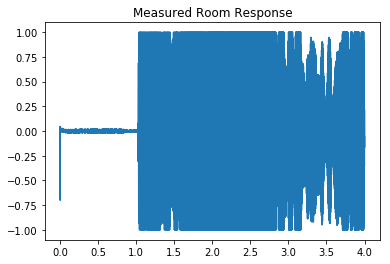

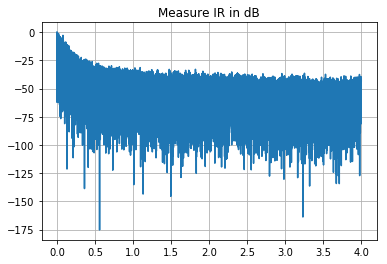

C:\Users\sengan\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


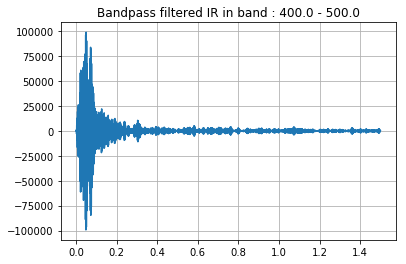

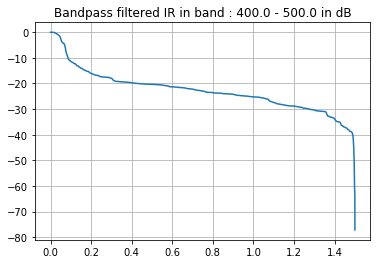

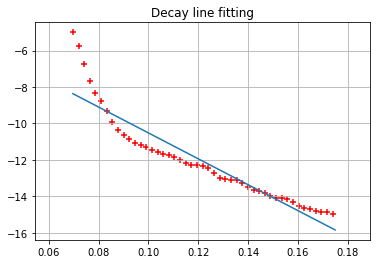

The reverberation time T60 is : 0.844299260263
With decay from ''-5.0'' to ''-15.0''


0.844299260262517

In [71]:
import wavio
fs = 44100
duration = 10
f_start=100.
f_stop=3150.
fraction = 3
noise_type='sine_sweep'

test = Test(noise_type=noise_type, f_start=f_start, f_stop=f_stop, fraction=fraction)

'''ir_file = '../../data/ir1_-_iringresso_new.wav'
ir = wavio.read(ir_file)
ir_data = ir.data[0:, 0]
ir_fs = ir.rate
print("IR : {0}").format(ir_data.shape)'''

room_response = wavio.read( '../../data/home/record_sweep_3.wav' )
rr = room_response.data[:,0]
rr = rr / math.pow(2.0, room_response.sampwidth*8-1)

ir_data = test.gen.estimate_impulse_response(rr, test.reverse_signal)
ir_fs = room_response.rate
t = np.arange(ir_data.size)/fs
T = fs*4

#wavio.write('../../data/home/record_sweep_3_ir.wav', ir_data, room_response.rate, sampwidth=room_response.sampwidth)
ir_data_abs = abs(ir_data)
db = 20 * np.log10(ir_data_abs / ir_data_abs.max())

plt.plot(t[:T], rr[:T])
plt.title('Measured Room Response')
plt.show()

plt.plot(t[:T], db[:T])
plt.title('Measure IR in dB')
#x_ = np.argmax(ir_data)
#plt.xlim([x_, x_+44100])
plt.grid()
plt.show()

ir_data = ir_data[:fs*1.5]
reverberation_time(ir_data, ir_fs)

In [14]:
from acoustics.standards.iec_61260_1_2014 import nominal_center_frequency

frequencies = OctaveBand(fstart=100., fstop=3150., fraction=3)
frequencies.center

array([  100.        ,   125.89254118,   158.48931925,   199.5262315 ,
         251.18864315,   316.22776602,   398.10717055,   501.18723363,
         630.95734448,   794.32823472,  1000.        ,  1258.92541179,
        1584.89319246,  1995.26231497,  2511.88643151,  3162.27766017])

In [21]:
a = np.array([[0,1,2,3,4,5]])
a[0,3]

3

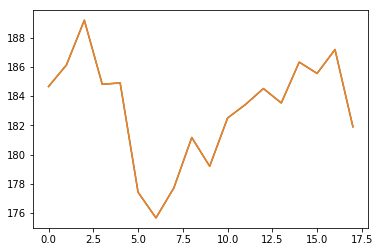

In [10]:
plt.plot(level)
plt.show()

Populating the interactive namespace from numpy and matplotlib
Sample length : 110250


`%matplotlib` prevents importing * from pylab and numpy


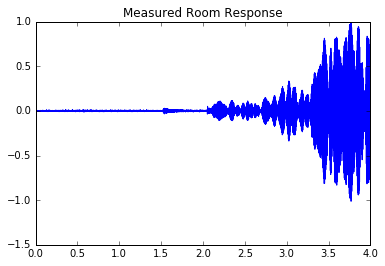

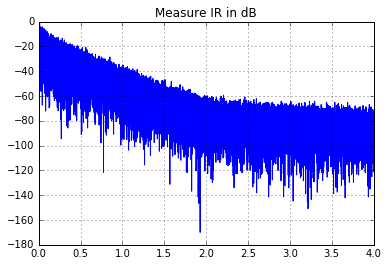

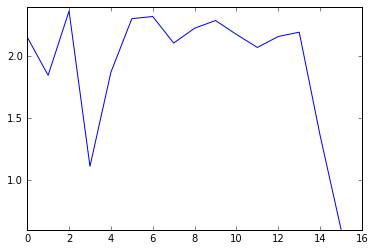

In [11]:
%pylab inline

duration = 10
f_start=100.
f_stop=5000.
fraction = 3
fs = 11025
noise_type='sine_sweep'

test = Test(fs=fs, noise_type=noise_type, f_start=f_start, f_stop=f_stop, fraction=fraction)


room_response = np.load('../../data/RT-Test/stair-case/2018-06-27-122815/source/5.npy')
rr = room_response[0:]
rr = rr / rr.max()

ir_data = test.gen.estimate_impulse_response(rr, test.reverse_signal)

t = np.arange(ir_data.size)/fs
T = fs*4

#wavio.write('../../data/home/record_sweep_3_ir.wav', ir_data, room_response.rate, sampwidth=room_response.sampwidth)
ir_data_abs = abs(ir_data)
db = 20 * np.log10(ir_data_abs / ir_data_abs.max())

plt.plot(t[:T], rr[:T])
plt.title('Measured Room Response')
plt.show()

plt.plot(t[:T], db[:T])
plt.title('Measure IR in dB')
#x_ = np.argmax(ir_data)
#plt.xlim([x_, x_+44100])
plt.grid()
plt.show()

ir_data = ir_data[:fs*1.5]

reverberation_time = test.reverberation_time(ir_data, fs, 'impulse', 't10')
plt.figure()
plt.plot(reverberation_time)
plt.show()

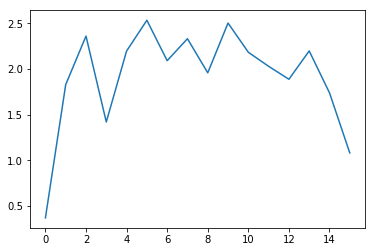

In [25]:
plt.plot(reverberation_time)
plt.show()

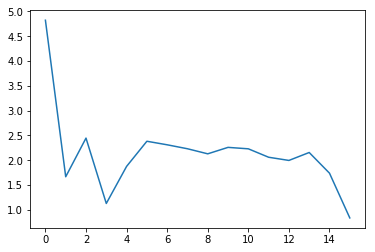

In [28]:
plt.plot(reverberation_time)
plt.show()

array([  125.89254118,   251.18864315,   501.18723363,  1000.        ,
        1995.26231497,  3981.07170553])